In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sys

sys.path.append('../../')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../../sci_style.py')

# Load Data

In [142]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [143]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [144]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [145]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [146]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

# Trajectories

In [147]:
leadup = 500
post = 1500
# leadup = 500
# post = 1500

In [148]:
def calc_row_idx(k, n):
    return int(math.ceil((1/2.) * (- (-8*k + 4 *n**2 -4*n - 7)**0.5 + 2*n -1) - 1))

def elem_in_i_rows(i, n):
    return i * (n - 1 - i) + (i*(i + 1))//2

def calc_col_idx(k, i, n):
    return int(n - elem_in_i_rows(i + 1, n) + k)

def condensed_to_square(k, n):
    i = calc_row_idx(k, n)
    j = calc_col_idx(k, i, n)
    return i, j

In [149]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'all'
}

In [150]:
wake_bounds = [0, session_info['drugStart'][0]]
anesthesia_bounds = [eyes_close, session_info['drugEnd'][1]]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

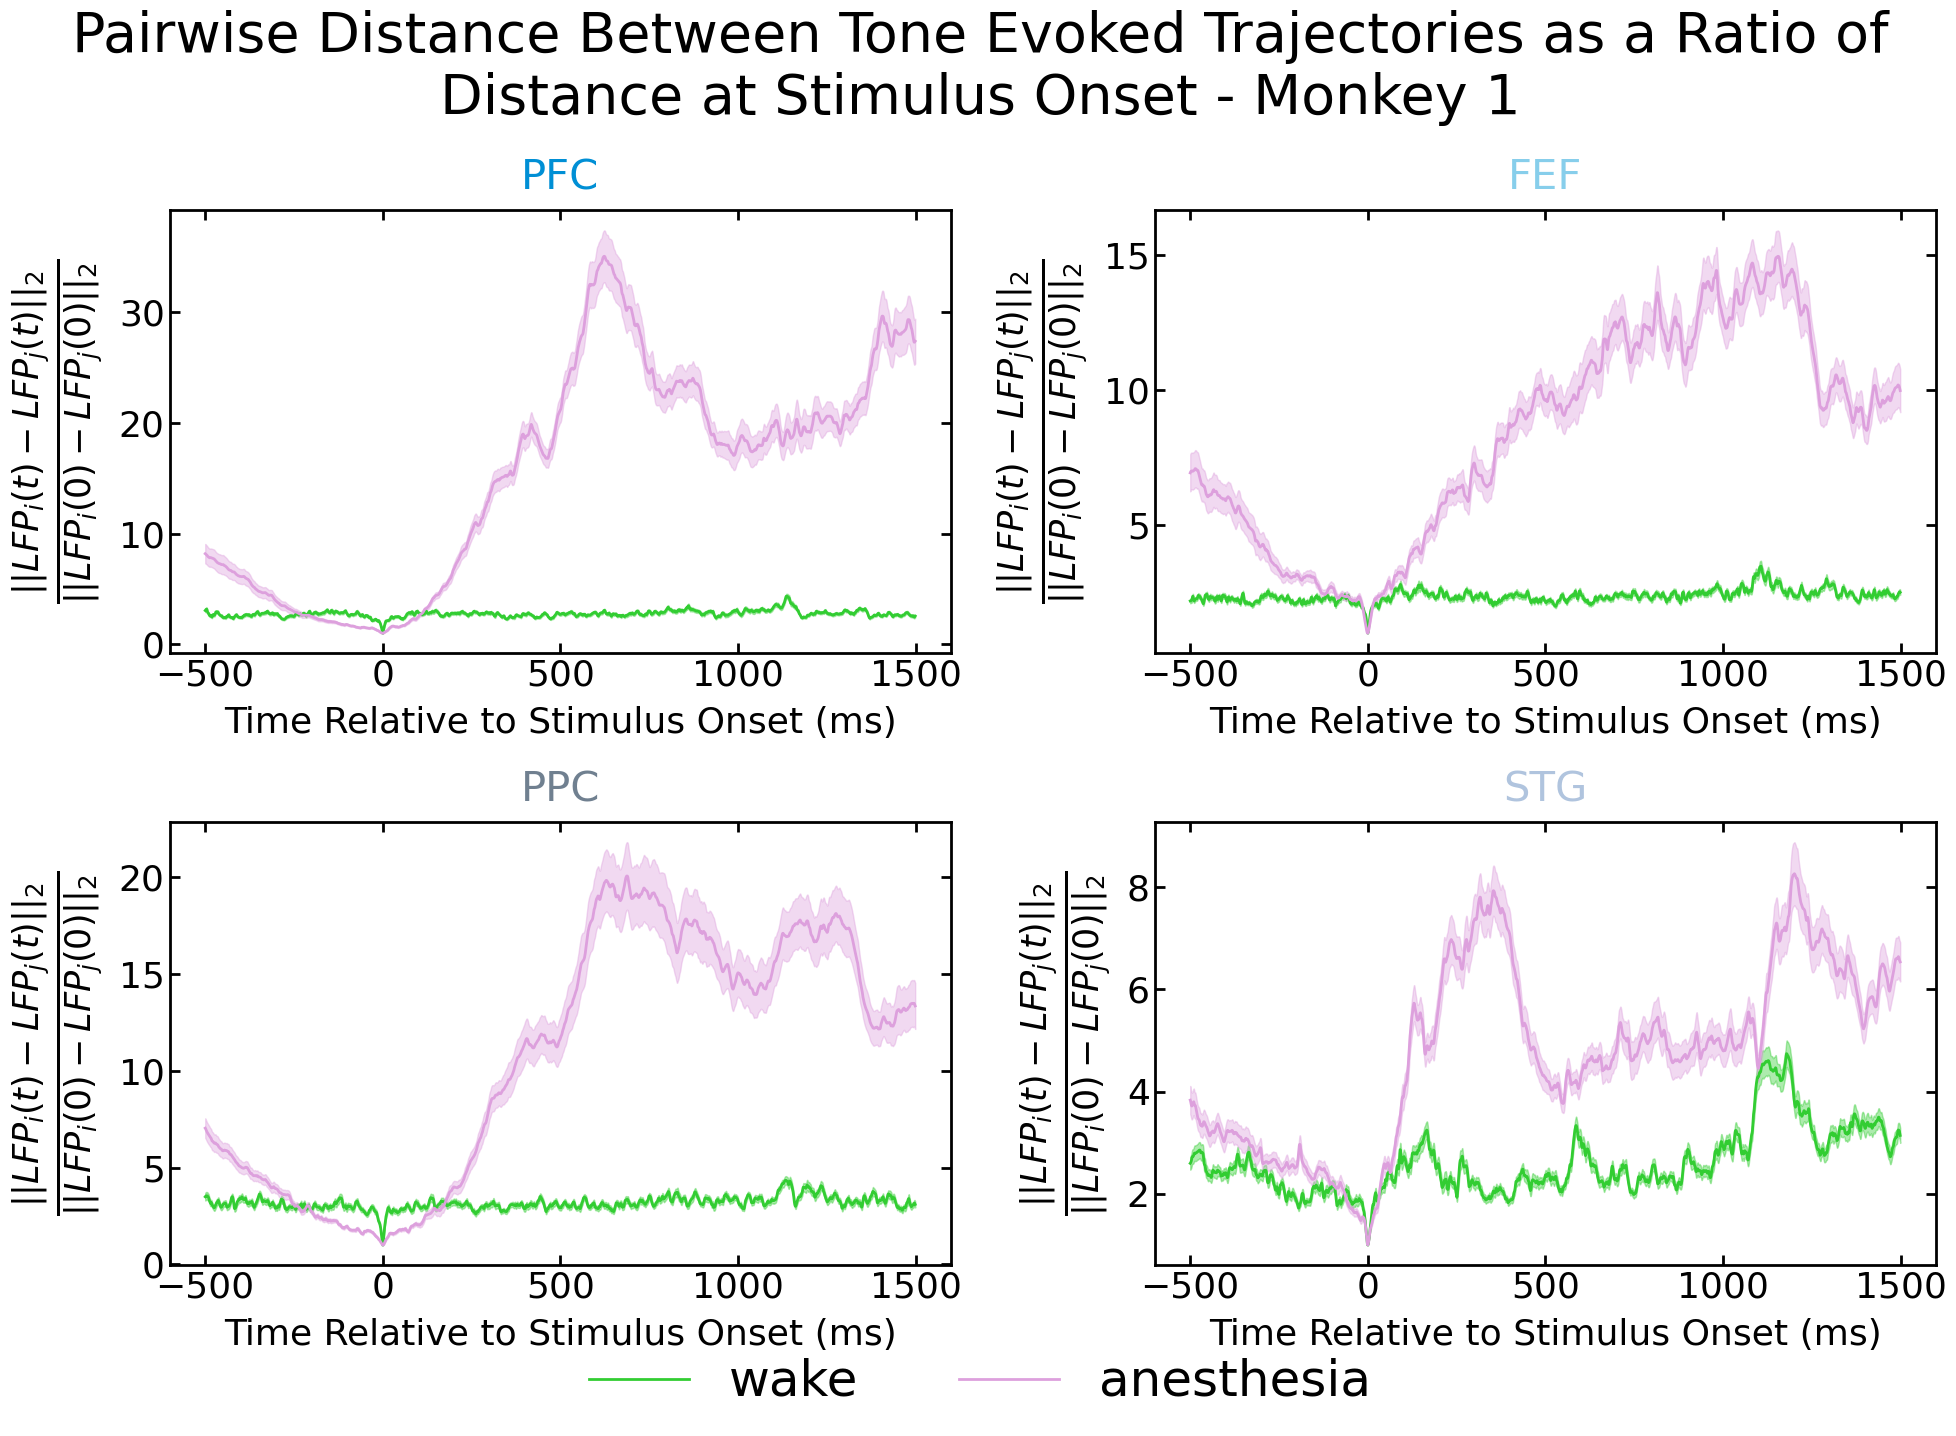

In [151]:
trajectory_times = tone_on

fig = plt.figure(figsize=(20, 14))
for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
# for i, area in enumerate(['vlPFC']):
    plt.subplot(2, 2, i + 1)
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]

    lfp_tone_wake = []
    lfp_tone_anesthesia = []
    num_wake = 0
    num_anesthesia = 0
    for t in trajectory_times:
        if t - leadup*dt > wake_bounds[0] and t + post*dt < wake_bounds[1]:
            t = int(t/dt)
            lfp_tone_wake.append(lfp[t - leadup:t + post, unit_indices])
            num_wake += 1
#         elif t > eyes_close and t < session_info['drugEnd'][1]:
        elif t - leadup*dt > anesthesia_bounds[0] and t + post*dt < anesthesia_bounds[1]:
            t = int(t/dt)
            lfp_tone_anesthesia.append(lfp[t - leadup:t + post, unit_indices])
            num_anesthesia += 1
    lfp_tone_wake = np.array(lfp_tone_wake)
    lfp_tone_anesthesia = np.array(lfp_tone_anesthesia)
    
#     NO PCA
    lfp_tone_wake_embed = lfp_tone_wake
    lfp_tone_anesthesia_embed = lfp_tone_anesthesia

#     # FIT PCA TO INDIVIDUAL TRAJECTORIES
#     n_components = 3
#     manifold_embed = PCA(n_components=n_components)
#     # manifold_embed = Isomap(n_components=3)
#     lfp_tone_wake_embed = np.zeros((lfp_tone_wake.shape[0], lfp_tone_wake.shape[1], n_components))
#     for i in tqdm(range(lfp_tone_wake.shape[0])):
#         lfp_tone_wake_embed[i] = manifold_embed.fit_transform(lfp_tone_wake[i])

#     lfp_tone_anesthesia_embed = np.zeros((lfp_tone_anesthesia.shape[0], lfp_tone_wake.shape[1], n_components))
#     for i in tqdm(range(lfp_tone_anesthesia.shape[0])):
#         lfp_tone_anesthesia_embed[i] = manifold_embed.fit_transform(lfp_tone_anesthesia[i])

    # FIT PCA TO THE MEAN TRAJECTORY
#     pca = PCA(n_components=3).fit(lfp_tone_wake.mean(axis=0))
#     lfp_tone_wake_embed = np.array([pca.transform(lfp_tone_wake[i]) for i in range(lfp_tone_wake.shape[0])])

#     pca = PCA(n_components=3).fit(lfp_tone_anesthesia.mean(axis=0))
#     lfp_tone_anesthesia_embed = np.array([pca.transform(lfp_tone_anesthesia[i]) for i in range(lfp_tone_anesthesia.shape[0])])

#     # interior normalization
#     lfp_tone_wake_embed = (lfp_tone_wake_embed - lfp_tone_wake_embed.mean(axis=(0, 1)))/lfp_tone_wake_embed.std(axis=(0,1))
#     lfp_tone_anesthesia_embed = (lfp_tone_anesthesia_embed - lfp_tone_anesthesia_embed.mean(axis=(0,1)))/lfp_tone_anesthesia_embed.std(axis=(0,1))
    lfp_tone_wake_embed = (lfp_tone_wake_embed - lfp_tone_wake_embed.mean())/lfp_tone_wake_embed.std()
    lfp_tone_anesthesia_embed = (lfp_tone_anesthesia_embed - lfp_tone_anesthesia_embed.mean())/lfp_tone_anesthesia_embed.std()
    
    n_wake = lfp_tone_wake_embed.shape[0]
    n_anesthesia = lfp_tone_anesthesia_embed.shape[0]
#     print(f"n_wake = {n_wake}, n_anesthesia = {n_anesthesia}")
#     num_min_inds = np.min([n_wake, n_anesthesia])
#     num_min_inds = np.min([int(n_wake*(n_wake + 1)/2 - n_wake), int(n_anesthesia*(n_anesthesia + 1)/2 - n_anesthesia)])
#     num_min_inds = np.max([n_wake, n_anesthesia])
    num_min_inds = 100
    
#     num_min_inds = n_wake
#     num_min_inds = int(n_wake*(n_wake + 1)/2 - n_wake)
    dist_wake_multi = np.zeros((num_min_inds, leadup + post))
    pdist_argsort = pdist(lfp_tone_wake_embed[:, leadup]).argsort()
    for min_ind in tqdm(range(num_min_inds)):
        ind = pdist_argsort[min_ind]
        traj_inds = condensed_to_square(ind, lfp_tone_wake_embed.shape[0])
        dist_wake = np.linalg.norm(lfp_tone_wake_embed[traj_inds[0]] - lfp_tone_wake_embed[traj_inds[1]], axis=1)
        ratio = dist_wake[leadup]
        dist_wake_multi[min_ind] = dist_wake/ratio
#         dist_wake_multi[min_ind] = np.log(dist_wake/ratio)
#         dist_wake_multi[min_ind] = dist_wake

#     num_min_inds = n_anesthesia
#     num_min_inds = int(n_anesthesia*(n_anesthesia + 1)/2 - n_anesthesia)
    dist_anesthesia_multi = np.zeros((num_min_inds, leadup + post))
    pdist_argsort = pdist(lfp_tone_anesthesia_embed[:, leadup]).argsort()
    for min_ind in tqdm(range(num_min_inds)):
        ind = pdist_argsort[min_ind]
        traj_inds = condensed_to_square(ind, lfp_tone_anesthesia_embed.shape[0])
        dist_anesthesia = np.linalg.norm(lfp_tone_anesthesia_embed[traj_inds[0]] - lfp_tone_anesthesia_embed[traj_inds[1]], axis=1)
        ratio = dist_anesthesia[leadup]
        dist_anesthesia_multi[min_ind] = dist_anesthesia/ratio
#         dist_anesthesia_multi[min_ind] = np.log(dist_anesthesia/ratio)
#         dist_anesthesia_multi[min_ind] = dist_anesthesia
    
#     # standardize
#     dist_wake_multi = (dist_wake_multi - dist_wake_multi.mean(axis=1).reshape(-1, 1))/dist_wake_multi.std(axis=1).reshape(-1, 1)
#     dist_anesthesia_multi = (dist_anesthesia_multi - dist_anesthesia_multi.mean(axis=1).reshape(-1, 1))/dist_anesthesia_multi.std(axis=1).reshape(-1, 1)

#     plt.title(f"{area_labels[area]}", fontsize=40)

    # ratio = 1
    mean_dist_wake = dist_wake_multi.mean(axis=0)
    se_dist_wake = dist_wake_multi.std(axis=0)/np.sqrt(dist_wake_multi.shape[0])
    lns = []
    lns += plt.plot(np.arange(-leadup, post), mean_dist_wake, c='limegreen', label='wake')
    plt.fill_between(np.arange(-leadup, post), mean_dist_wake - se_dist_wake, mean_dist_wake + se_dist_wake, color='limegreen', alpha=0.4)

    mean_dist_anesthesia = dist_anesthesia_multi.mean(axis=0)
    se_dist_anesthesia = dist_anesthesia_multi.std(axis=0)/np.sqrt(dist_anesthesia_multi.shape[0])
    lns += plt.plot(np.arange(-leadup, post), mean_dist_anesthesia, c='plum', label='anesthesia')
    plt.fill_between(np.arange(-leadup, post), mean_dist_anesthesia - se_dist_anesthesia, mean_dist_anesthesia + se_dist_anesthesia, color='plum', alpha=0.4)
    plt.xlabel('Time Relative to Stimulus Onset (ms)', fontsize=26)
#     plt.legend()
    plt.ylabel(r"$\frac{||LFP_i(t) - LFP_j(t)||_2}{||LFP_i(0) - LFP_j(0)||_2}$", fontsize=36)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.tick_params(axis='both', which='minor', labelsize=26)
    ax.set_title(area_labels[area], c=area_colors[area], fontsize=30)

plt.suptitle(f"Pairwise Distance Between Tone Evoked Trajectories as a Ratio of\nDistance at Stimulus Onset - Monkey {1 if 'Mary' in session else 2}", fontsize=40)
fig.legend(lns, [ln.get_label() for ln in lns], fontsize=36, ncol=2, bbox_to_anchor=(0.5, 0), loc='center')
plt.tight_layout()
plt.show()

In [152]:
# plt.figure(figsize=(18, 4))
# plt.subplot(1, 2, 1)
# plt.hist(tone_on)
# plt.title('Histogram of Tone Start Times')
# plt.xlabel('Time in Session (s)')
# plt.subplot(1, 2, 2)
# plt.hist(trajectory_times)
# plt.title('Histogram of Randomly Sampled Times')
# plt.xlabel('Time in Session (s)')
# plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

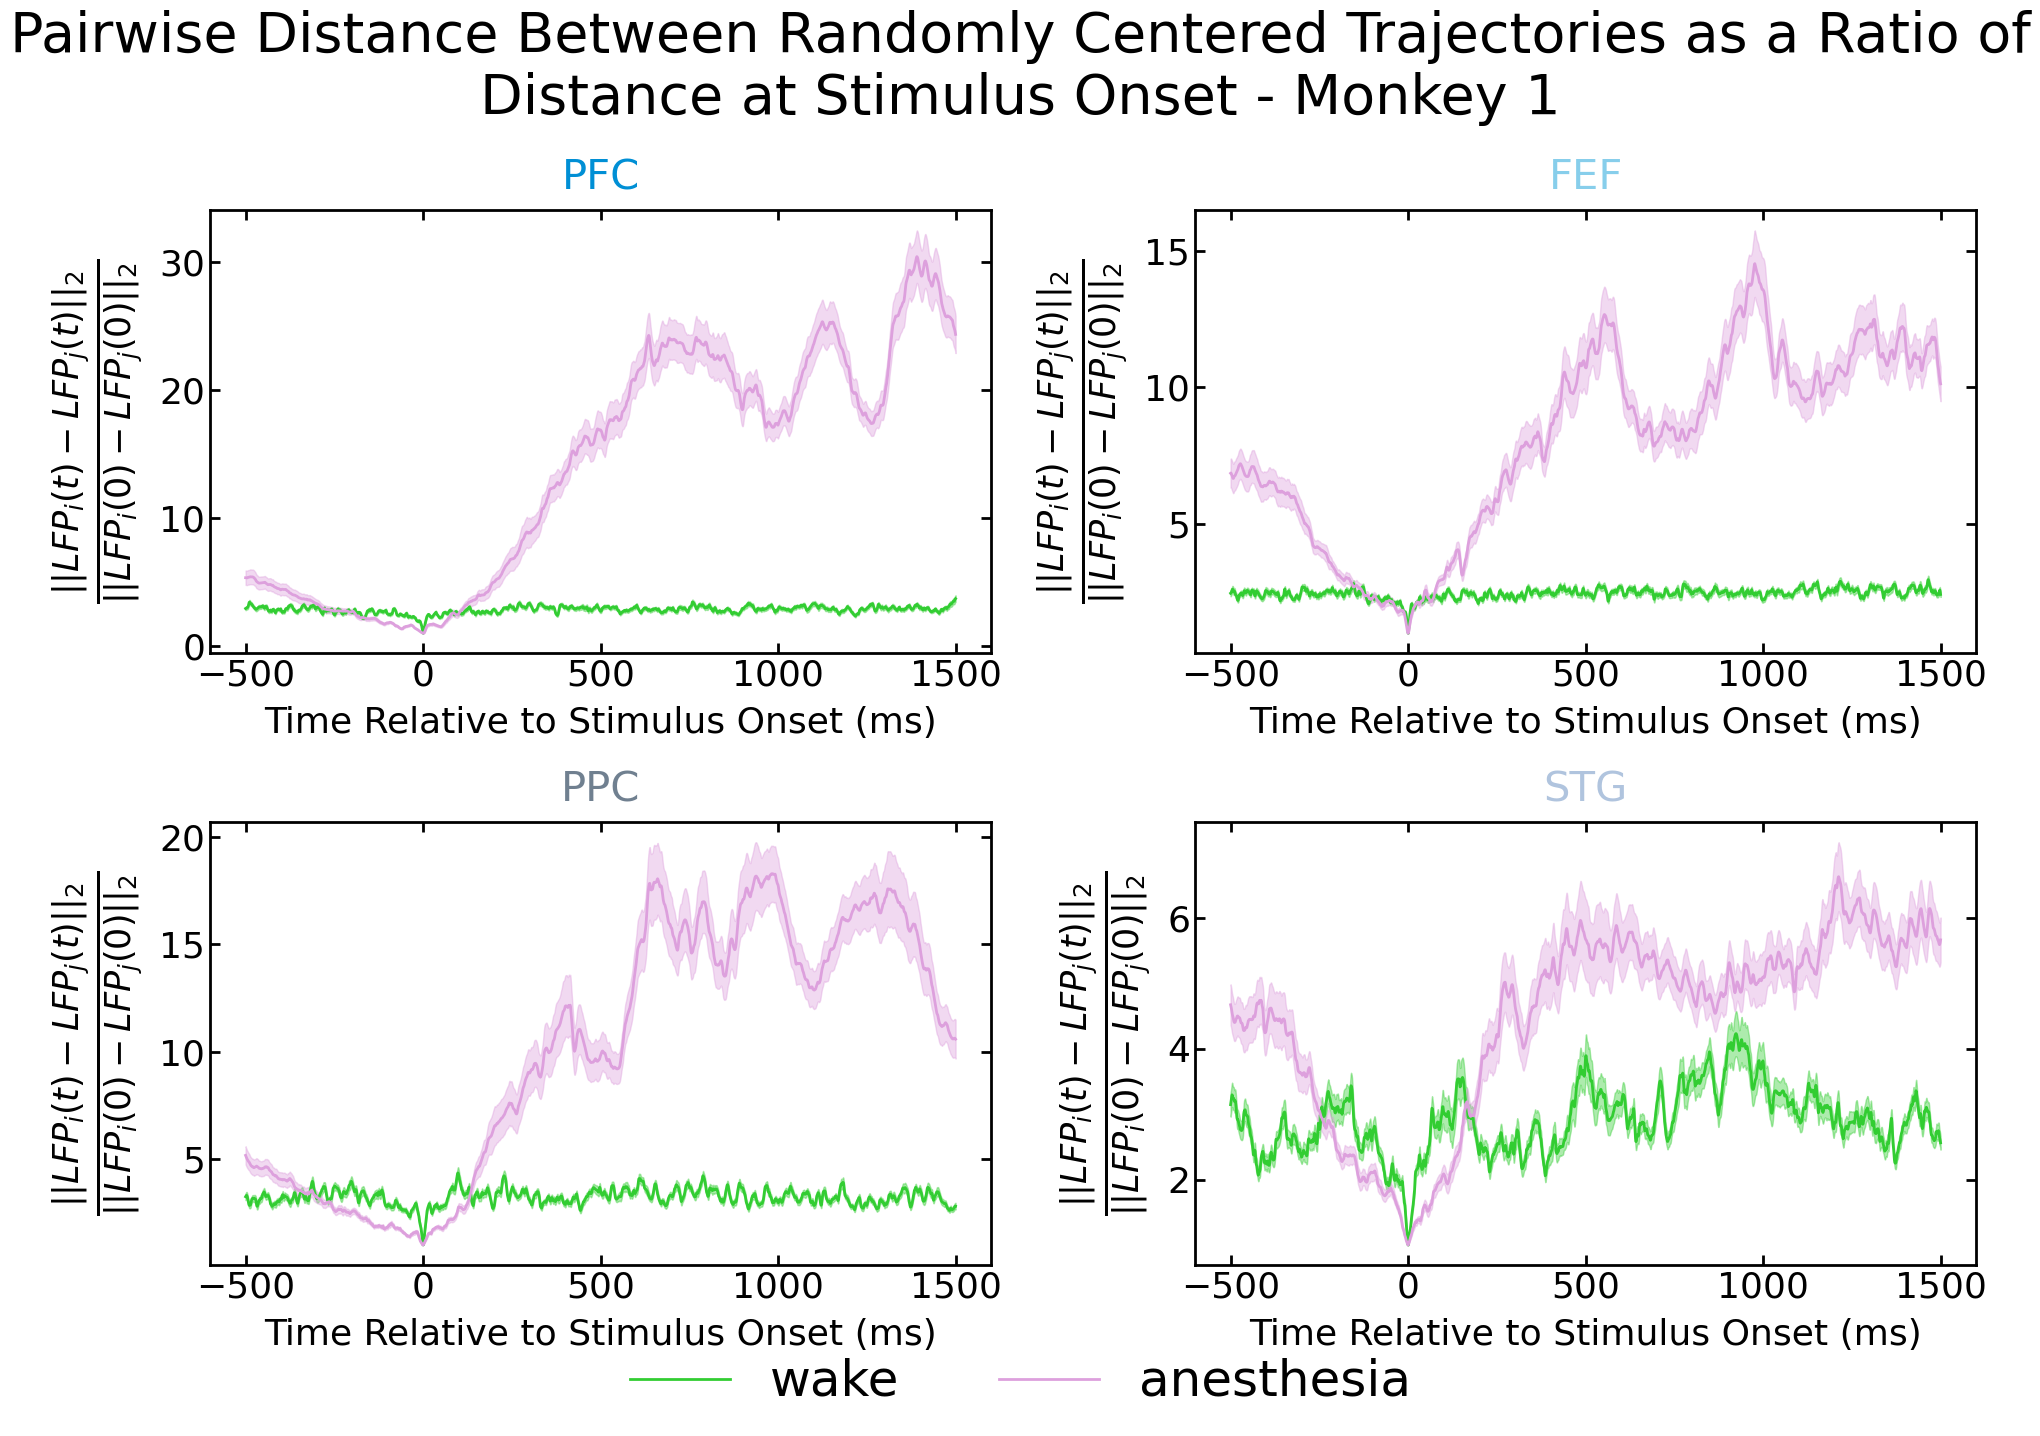

In [153]:
wake_ts = np.random.uniform(wake_bounds[0] + leadup*dt, wake_bounds[1] - post*dt, size=(n_wake,))
anesthesia_ts = np.random.uniform(anesthesia_bounds[0] + leadup*dt, anesthesia_bounds[1] - post*dt, size=(n_anesthesia,))
trajectory_times = np.hstack([wake_ts, anesthesia_ts])

fig = plt.figure(figsize=(20, 14))
for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
# for i, area in enumerate(['vlPFC']):
    plt.subplot(2, 2, i + 1)
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]

    lfp_tone_wake = []
    lfp_tone_anesthesia = []
    num_wake = 0
    num_anesthesia = 0
    for t in trajectory_times:
         if t + post*dt < wake_bounds[1] and t > wake_bounds[0]:
            t = int(t/dt)
            lfp_tone_wake.append(lfp[t - leadup:t + post, unit_indices])
            num_wake += 1
#         elif t > eyes_close and t < session_info['drugEnd'][1]:
         elif t > anesthesia_bounds[0] and t + post*dt < anesthesia_bounds[1]:
            t = int(t/dt)
            lfp_tone_anesthesia.append(lfp[t - leadup:t + post, unit_indices])
            num_anesthesia += 1
    lfp_tone_wake = np.array(lfp_tone_wake)
    lfp_tone_anesthesia = np.array(lfp_tone_anesthesia)
    
    # NO PCA
    lfp_tone_wake_embed = lfp_tone_wake
    lfp_tone_anesthesia_embed = lfp_tone_anesthesia

#     # FIT PCA TO INDIVIDUAL TRAJECTORIES
#     n_components = 3
#     manifold_embed = PCA(n_components=n_components)
#     # manifold_embed = Isomap(n_components=3)
#     lfp_tone_wake_embed = np.zeros((lfp_tone_wake.shape[0], lfp_tone_wake.shape[1], n_components))
#     for i in tqdm(range(lfp_tone_wake.shape[0])):
#         lfp_tone_wake_embed[i] = manifold_embed.fit_transform(lfp_tone_wake[i])

#     lfp_tone_anesthesia_embed = np.zeros((lfp_tone_anesthesia.shape[0], lfp_tone_wake.shape[1], n_components))
#     for i in tqdm(range(lfp_tone_anesthesia.shape[0])):
#         lfp_tone_anesthesia_embed[i] = manifold_embed.fit_transform(lfp_tone_anesthesia[i])

#     # FIT PCA TO THE MEAN TRAJECTORY
#     pca = PCA(n_components=3).fit(lfp_tone_wake.mean(axis=0))
#     lfp_tone_wake_embed = np.array([pca.transform(lfp_tone_wake[i]) for i in range(lfp_tone_wake.shape[0])])

#     pca = PCA(n_components=3).fit(lfp_tone_anesthesia.mean(axis=0))
#     lfp_tone_anesthesia_embed = np.array([pca.transform(lfp_tone_anesthesia[i]) for i in range(lfp_tone_anesthesia.shape[0])])

    # interior normalization
#     lfp_tone_wake_embed = (lfp_tone_wake_embed - lfp_tone_wake_embed.mean(axis=(0, 1)))/lfp_tone_wake_embed.std(axis=(0,1))
#     lfp_tone_anesthesia_embed = (lfp_tone_anesthesia_embed - lfp_tone_anesthesia_embed.mean(axis=(0,1)))/lfp_tone_anesthesia_embed.std(axis=(0,1))
    lfp_tone_wake_embed = (lfp_tone_wake_embed - lfp_tone_wake_embed.mean())/lfp_tone_wake_embed.std()
    lfp_tone_anesthesia_embed = (lfp_tone_anesthesia_embed - lfp_tone_anesthesia_embed.mean())/lfp_tone_anesthesia_embed.std()
    num_min_inds = 100
    
#     num_min_inds = n_wake
#     num_min_inds = int(n_wake*(n_wake + 1)/2 - n_wake)
    dist_wake_multi = np.zeros((num_min_inds, leadup + post))
    pdist_argsort = pdist(lfp_tone_wake_embed[:, leadup]).argsort()
    
    for min_ind in tqdm(range(num_min_inds)):
        ind = pdist_argsort[min_ind]
        traj_inds = condensed_to_square(ind, lfp_tone_wake_embed.shape[0])
        dist_wake = np.linalg.norm(lfp_tone_wake_embed[traj_inds[0]] - lfp_tone_wake_embed[traj_inds[1]], axis=1)
        ratio = dist_wake[leadup]
        dist_wake_multi[min_ind] = dist_wake/ratio
#         dist_wake_multi[min_ind] = np.log(dist_wake/ratio)
#         dist_wake_multi[min_ind] = dist_wake
    
#     num_min_inds = n_anesthesia
#     num_min_inds = int(n_anesthesia*(n_anesthesia + 1)/2 - n_anesthesia)
    dist_anesthesia_multi = np.zeros((num_min_inds, leadup + post))
    pdist_argsort = pdist(lfp_tone_anesthesia_embed[:, leadup]).argsort()
    for min_ind in tqdm(range(num_min_inds)):
        ind = pdist_argsort[min_ind]
        traj_inds = condensed_to_square(ind, lfp_tone_anesthesia_embed.shape[0])
        dist_anesthesia = np.linalg.norm(lfp_tone_anesthesia_embed[traj_inds[0]] - lfp_tone_anesthesia_embed[traj_inds[1]], axis=1)
        ratio = dist_anesthesia[leadup]
        dist_anesthesia_multi[min_ind] = dist_anesthesia/ratio
#         dist_anesthesia_multi[min_ind] = np.log(dist_anesthesia/ratio)
#         dist_anesthesia_multi[min_ind] = dist_anesthesia
    
    # standardize
#     dist_wake_multi = (dist_wake_multi - dist_wake_multi.mean(axis=1).reshape(-1, 1))/dist_wake_multi.std(axis=1).reshape(-1, 1)
#     dist_anesthesia_multi = (dist_anesthesia_multi - dist_anesthesia_multi.mean(axis=1).reshape(-1, 1))/dist_anesthesia_multi.std(axis=1).reshape(-1, 1)

#     plt.title(f"{area_labels[area]}", fontsize=40)

    # ratio = 1
    mean_dist_wake = dist_wake_multi.mean(axis=0)
    se_dist_wake = dist_wake_multi.std(axis=0)/np.sqrt(dist_wake_multi.shape[0])
    lns = []
    lns += plt.plot(np.arange(-leadup, post), mean_dist_wake, c='limegreen', label='wake')
    plt.fill_between(np.arange(-leadup, post), mean_dist_wake - se_dist_wake, mean_dist_wake + se_dist_wake, color='limegreen', alpha=0.4)

    mean_dist_anesthesia = dist_anesthesia_multi.mean(axis=0)
    se_dist_anesthesia = dist_anesthesia_multi.std(axis=0)/np.sqrt(dist_anesthesia_multi.shape[0])
    lns += plt.plot(np.arange(-leadup, post), mean_dist_anesthesia, c='plum', label='anesthesia')
    plt.fill_between(np.arange(-leadup, post), mean_dist_anesthesia - se_dist_anesthesia, mean_dist_anesthesia + se_dist_anesthesia, color='plum', alpha=0.4)
    plt.xlabel('Time Relative to Stimulus Onset (ms)', fontsize=26)
#     plt.legend()
    plt.ylabel(r"$\frac{||LFP_i(t) - LFP_j(t)||_2}{||LFP_i(0) - LFP_j(0)||_2}$", fontsize=36)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.tick_params(axis='both', which='minor', labelsize=26)
    ax.set_title(area_labels[area], c=area_colors[area], fontsize=30)
    
plt.suptitle(f"Pairwise Distance Between Randomly Centered Trajectories as a Ratio of\nDistance at Stimulus Onset - Monkey {1 if 'Mary' in session else 2}", fontsize=40)
fig.legend(lns, [ln.get_label() for ln in lns], fontsize=36, ncol=2, bbox_to_anchor=(0.5, 0), loc='center')
plt.tight_layout()
plt.show()

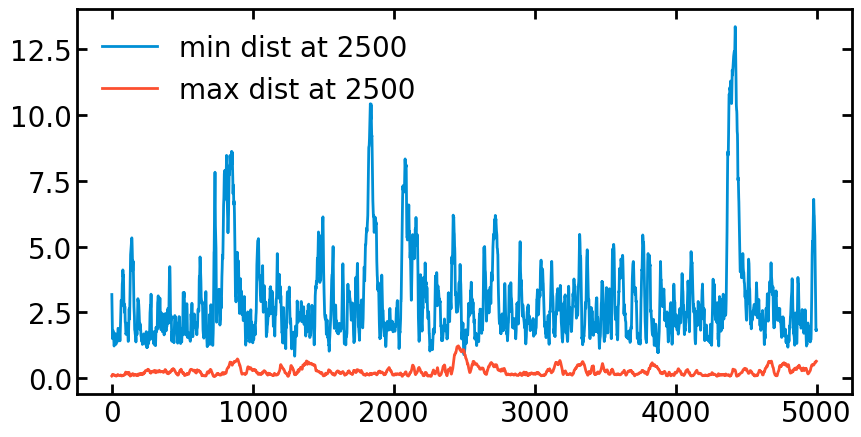

In [108]:
plt.plot(dist_wake_multi[0]/dist_wake_multi[0, 2500], label='min dist at 2500')
plt.plot(dist_wake_multi[-1]/dist_wake_multi[-1, 2500], label='max dist at 2500')
plt.legend()
plt.show()

# Checking Something

In [171]:
wake_signal = lfp[60000:75000, np.where(electrode_info['area'] == 'vlPFC')[0]]
anesthesia_signal = lfp[int(2700*1000):int(2700*1000) + 15000, np.where(electrode_info['area'] == 'vlPFC')[0]]

In [186]:
%%time
delase = DeLASE(wake_signal, 100, dt=dt, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=0.1, lamb=0.02)
delase.compute_jacobians()
delase.get_stability(max_freq=500, max_unstable_freq=125)
wake_stab = delase.stability_params.cpu()
del delase

CPU times: user 2min 55s, sys: 22.5 s, total: 3min 17s
Wall time: 2min 40s


In [187]:
%%time
delase = DeLASE(anesthesia_signal, 100, dt=dt, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=0.1, lamb=0.02)
delase.compute_jacobians()
delase.get_stability(max_freq=500, max_unstable_freq=125)
anesthesia_stab = delase.stability_params.cpu()
del delase

CPU times: user 2min 45s, sys: 21 s, total: 3min 6s
Wall time: 2min 23s


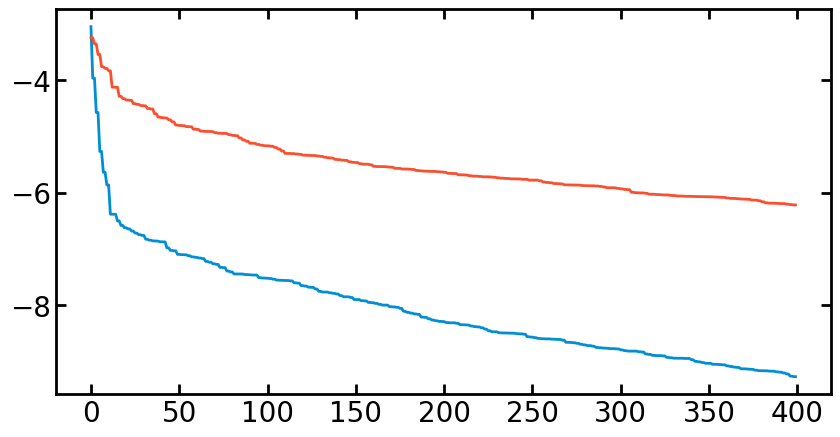

In [190]:
plt.plot(wake_stab[:400])
plt.plot(anesthesa_stab[:400])

In [195]:
wake_signal_normed = (wake_signal - wake_signal.mean(axis=0))/wake_signal.std(axis=0)
anesthesia_signal_normed = (anesthesia_signal - anesthesia_signal.mean(axis=0))/anesthesia_signal.std(axis=0)

In [196]:
%%time
delase = DeLASE(wake_signal_normed, 100, dt=dt, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=0.1, lamb=0.02)
delase.compute_jacobians()
delase.get_stability(max_freq=500, max_unstable_freq=125)
wake_stab_normed = delase.stability_params.cpu()
del delase

CPU times: user 2min 34s, sys: 20.9 s, total: 2min 55s
Wall time: 1min 56s


In [197]:
%%time
delase = DeLASE(anesthesia_signal_normed, 100, dt=dt, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=0.1, lamb=0.02)
delase.compute_jacobians()
delase.get_stability(max_freq=500, max_unstable_freq=125)
anesthesa_stab_normed = delase.stability_params.cpu()
del delase

CPU times: user 2min 32s, sys: 21.1 s, total: 2min 53s
Wall time: 1min 55s


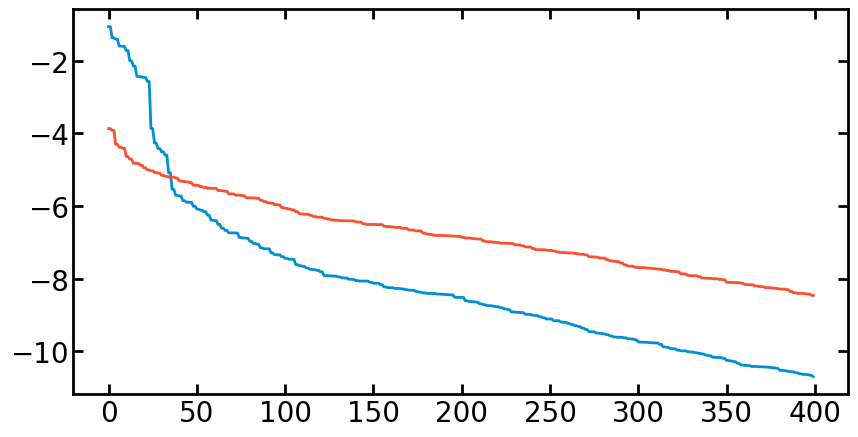

In [198]:
plt.plot(wake_stab_normed[:400])
plt.plot(anesthesa_stab_normed[:400])